In [1]:
#%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
import struct, os, math, random
from matplotlib import rc, font_manager
from numpy import pi, arcsin, cos, sin, percentile, exp

try:
    os.system('rm /Users/Lucas/.matplotlib/fontlist-v310.json')
except FileNotFoundError:
    pass
    
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)

import matplotlib
matplotlib.rcParams.update({'font.size': 14})
from mpl_toolkits.basemap import Basemap

from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy import units as u
import datetime

import matplotlib.animation as animation
from matplotlib.widgets import Slider

from mpl_toolkits import mplot3d

try:
    from itertools import izip_longest  # added in Py 2.6
except ImportError:
    from itertools import zip_longest as izip_longest  # name change in Py 3.x

try:
    from itertools import accumulate  # added in Py 3.2
except ImportError:
    def accumulate(iterable):
        'Return running totals (simplified version).'
        total = next(iterable)
        yield total
        for value in iterable:
            total += value
            yield total

In [2]:
def get_file(path):
    #opens and external file and makes it into a list
    fopen = path
    f=open(fopen, 'r+')
    g=list(f)
    g=map(lambda s: s.strip(), g)
    return np.array(list(g))

def splitt(old_list):
    #splits the list entries into sublists
    new_list=[]
    for i in old_list:
        new_list+=[i.split()]
    return new_list

def make_vector(m, col):
    x=[]
    for i in m:
        x+=[i[col]]
    return x

def refine_fits(old_list, length_cat, symbol_cat, 
    column_search_number, column_retrival_number):
    #to refine an imported list after the use of get_file()
    #to remove header information or filter the list
    # only works for 2-dim type objects
    #symbol_cat is a single character
    tmp_list=[]
    if not length_cat==None:
        for i in old_list:
            if len(i)==length_cat:
                tmp_list+=[i]
    else:
        tmp_list=old_list
    tmp_list_2=[]
    if not symbol_cat==None:
        for i in tmp_list:
            if not column_search_number==None:
                column=i[column_search_number-1] #searches specific column for match
            else:
                column=i #searches all columns.
            for row_element in column: #searching rows in columns
                if row_element.count(symbol_cat)>0:
                    tmp_list_2+=[column]
                    break #ends if it finds it to prevent line repeats
                else:
                    continue #continues to look if it doesn't
    else:
        tmp_list_2=tmp_list
    tmp_list_3=[]
    if column_search_number==None:
        if not column_retrival_number==None:
            for i in tmp_list_2:
                tmp_list_3+=[i[column_retrival_number-1]]
        else:
            tmp_list_3=tmp_list_2
    else:
        tmp_list_3=tmp_list_2
    tmp_list_4 = []
    for k in range(len(tmp_list_3)):
        if 'localhos' not in tmp_list_3[k]:
            tmp_list_4+=[tmp_list_3[k]]
    return tmp_list_4

            
def make_parser(fieldwidths):
    cuts = tuple(cut for cut in accumulate(abs(fw) for fw in fieldwidths))
    pads = tuple(fw < 0 for fw in fieldwidths) # bool values for padding fields
    flds = tuple(izip_longest(pads, (0,)+cuts, cuts))[:-1]  # ignore final one
    parse = lambda line: tuple(line[i:j] for pad, i, j in flds if not pad)
    # optional informational function attributes
    parse.size = sum(abs(fw) for fw in fieldwidths)
    parse.fmtstring = ' '.join('{}{}'.format(abs(fw), 'x' if fw < 0 else 's')
                                                for fw in fieldwidths)
    return parse

def read_jmfit(path):
    fieldwidths = (10,-7,7,-2,6,-6,6,-3,5,-6,6,-3,5)
    parse = make_parser(fieldwidths)
    File = list(get_file(path))[1:]
    outFile = []
    for line in File:
        outFile.append(np.asarray(parse(line)))
    return np.asarray(outFile)

def read_source_names(file):
    SUtable = refine_fits(splitt(get_file(file))[17:],5,None,None,None)+refine_fits(splitt(get_file(file))[17:],6,None,None,None)
    source_names = {}
    for i in range(len(SUtable)):
        source_names.update({SUtable[i][2]:SUtable[i][1]})
    return source_names

def read_source_positions(file):
    deg_rad = pi/180.0
    SUtable = refine_fits(splitt(get_file(file))[17:],5,None,None,None)
    ra = make_vector(SUtable,3)
    dec= make_vector(SUtable,4)
    RA = replaceDE(ra)
    DEC= replaceDE(dec)
    source_position = {}
    for i in range(len(SUtable)):
        source_position.update({SUtable[i][1]:(float(RA[i])*deg_rad,float(DEC[i])*deg_rad)})
    ###
    SUtable = refine_fits(splitt(get_file(file))[17:],6,None,None,None)
    ra = make_vector(SUtable,4)
    dec= make_vector(SUtable,5)
    RA = replaceDE(ra)
    DEC= replaceDE(dec)
    for i in range(len(SUtable)):
        source_position.update({SUtable[i][1]:(float(RA[i])*deg_rad,float(DEC[i])*deg_rad)})
    return source_position

def replaceDE(vector):
    vector_2 = []
    for i in range(len(vector)):
        vector_2+=[vector[i].replace('D','E')]
    return vector_2

def calc_distance(nametokey='',keytopos='',refs=['',''],array=''):
    for ref in refs:
        try: 
            ref_pos = np.array(keytopos[nametokey[ref]])
            continue
        except KeyError:
            pass
    pos = []
    for name in array:
        pos.append(np.array(keytopos[nametokey[name]]))
    p = np.asarray(pos)
    return (((p[:,0]-ref_pos[0])*np.cos(ref_pos[1]))**2+(p[:,1]-ref_pos[1])**2)**0.5

def read_multiband_delays(file):
    Mtable = refine_fits(splitt(get_file(file))[20:],7,None,None,None)
    return Mtable

def read_multiband_delays2(file):
    SN     = list(get_file(file))
    indx   = int(SN.index('***BEGIN*PASS***')+1)
    header = SN[:indx] #keep header intact for later
    data   = splitt(SN[indx:-1])
    ender  = SN[-1]
    return header,data,ender

def determine_ref_ant(mdel_table):
    sample = make_vector(mdel_table,-1)
    choice = random.choice(sample)
    return choice

def clean_INDE_and_D(list_list):
    for i in range(len(list_list)):
        for j in range(len(list_list[i])):
            if list_list[i][j]=="'INDE'":
                list_list[i][j]=9999.9
            else:
                list_list[i][j]=float(list_list[i][j].replace('D','E'))
    return list_list

def extract_telescope_phase(table,n_antennas):
    ptable={}
    for j in range(n_antennas):
        ptable.update({j:[]})
    for i in range(len(table)):
        ptable[int(table[i][2]-1)]+=[table[i]]
    return ptable

def extract_telescope_rate(table,n_antennas):
    rtable={}
    for j in range(n_antennas):
        rtable.update({j:[]})
    for i in range(len(table)):
        rtable[int(table[i][2]-1)]+=[table[i]]
    return rtable

def phase2(vec1,vec2):
    p = []
    for i in range(len(vec1)):
        if vec2[i]==None or vec1[i]==None:
            p+=[None]
        elif vec2[i]=='INDE' or vec1[i]=='INDE':
            p+=[np.inf]
        elif vec2[i]==9999.9 or vec1[i]==9999.9:
            p+=[np.nan]
        else:
            p+=[2*np.arctan(float(vec2[i])/(((float(vec1[i]))**2+(float(vec2[i]))**2)**0.5+float(vec1[i])))]
    return np.array(p)

def updownmedian(arr):
    med = np.median(arr)
    up  = med-np.percentile(arr,25)
    dwn = np.percentile(arr,75)-med
    return (med,up,dwn)

def read_jpltec(tecfile):
    start    = [s for s in tecfile if 'HEADER' in s][0]
    tecends  = [s for s in tecfile if 'END OF TEC MAP' in s]
    rmsends  = [s for s in tecfile if 'END OF RMS MAP' in s]
    header   = tecfile[:np.where(tecfile==start)[0][0]-1]
    data     = tecfile[ np.where(tecfile==start)[0][0]+1:np.where(tecfile==tecends[-1])[0][0]]
    rdat     = tecfile[ np.where(tecfile==tecends[-1])[0][0]+1:np.where(tecfile==rmsends[-1])[0][0]]

    # read tec map
    tecstart = np.array([np.where(data==s)[0][0] for s in data if 'START OF TEC MAP' in s])
    lat = []
    for m in range(len(tecstart)):
        tmap = data[tecstart[m]+1:tecstart[m]+428]

    # read rms map
    rmsstart = np.array([np.where(rdat==s)[0][0] for s in rdat if 'START OF RMS MAP' in s])
    for m in range(len(rmsstart)):
        rmap = data[rmsstart[m]+1:rmsstart[m]+428]

    t, lat, long = [], np.arange(87.5,-87.6,-2.5), np.arange(-180,180.1,5)
    tec  = np.zeros(shape=(len(lat),len(long),12))
    rms  = np.zeros(shape=(len(lat),len(long),12))
    for m in range(12):
        # format tec map
        tmap        = data[tecstart[m]+1:tecstart[m]+428]
        time_string = tmap[0].split()
        map_t       = datetime.datetime(year=int(time_string[0]),month=int(time_string[1]),day=int(time_string[2]),
                     hour=int(time_string[3]),minute=int(time_string[4]),second=int(time_string[5]))
        latstart = np.array([np.where(tmap==s)[0][0] for s in tmap if 'LAT/LON1/LON2/DLON/H' in s])
        for n in range(len(lat)):
            tec[n,:,m] = np.array([s for d in splitt(tmap[latstart[n]+1:latstart[n]+6]) for s in d],dtype='float')
        ####################################################
        rmap = rdat[rmsstart[m]+1:rmsstart[m]+428]
        rlatstar = np.array([np.where(rmap==s)[0][0] for s in rmap if 'LAT/LON1/LON2/DLON/H' in s])
        for n in range(len(lat)):
            rms[n,:,m] = np.array([s for d in splitt(rmap[rlatstar[n]+1:rlatstar[n]+6]) for s in d],dtype='float')
        t.append(map_t)
    return Time(t,location=('0d', '0d')), long, lat, tec*0.1, rms*0.1

def splitt2(old_list,char):
    #splits the list entries into sublists
    new_list=[]
    for i in old_list:
        new_list+=[i.split(char)]
    return np.array(new_list)

In [3]:
tecfile = get_file('/Users/Lucas/spirals/testing/jplg2280.20i');

t, long, lat, tec, rms = read_jpltec(tecfile)

In [4]:
source = SkyCoord(ra='15:31:45.4500',dec='-56:30:50.100',unit=(u.hourangle,u.deg))
gst = 15*t.sidereal_time('apparent').value

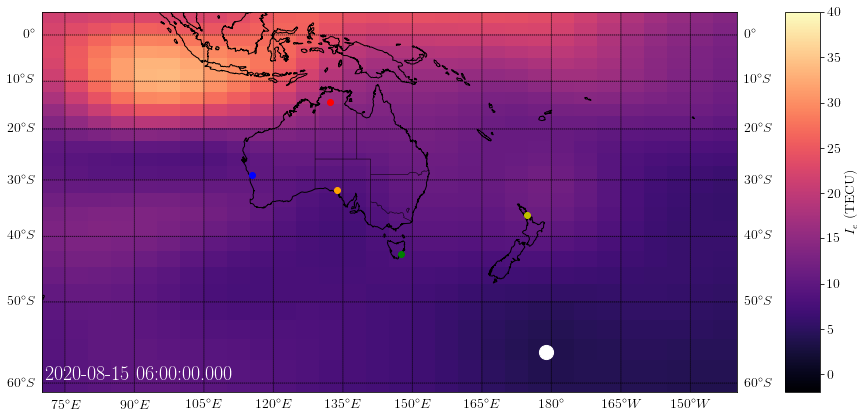

In [32]:
x, y = np.meshgrid(long, lat)
fig, ax = plt.subplots(1,figsize=(14,7))

ax = Basemap(llcrnrlon=70.,llcrnrlat=-61.,urcrnrlon=220.,urcrnrlat=5.,\
            rsphere=(6378137.00,6356752.3142),\
            resolution='l',projection='merc',ax=ax)
ax.drawcoastlines()
ax.drawstates()

for AX in [ax]:
    AX.scatter(147.440,-42.804,latlon=True,color='g',zorder=99)
    AX.scatter(133.809,-31.868,latlon=True,color='orange',zorder=99)
    AX.scatter(115.35,-29.047,latlon=True,color='b',zorder=99)
    AX.scatter(132.15,-14.375,latlon=True,color='r',zorder=99)
    AX.scatter([174.66],[-36.43],latlon=True,color='y',zorder=99)
    
ax.drawparallels(np.arange(-90,90,10),labels=[1,1,0,1]);
ax.drawmeridians(np.arange(-180,180,15),labels=[1,1,0,1]);

m=0

plot0 = [ax.pcolor(x,y,tec[:,:,m], latlon=True,cmap='magma',vmin=-2,vmax=40)]
plot1 = [ax.scatter([source.ra.deg-gst[m]],[source.dec.deg],latlon=True,color='w',s=200,zorder=99)]
plot2 = [fig.text(0.13,0.15,s=f'{t.iso[m]}',color='w',size=20)]
c = plot0[0]
ax.colorbar(c,pad='7%',label=R'$I_e$ (TECU)')

def update(m,t,gst,source,x,y,tec,plot0,plot1,plot2):
    plot0[0].remove()
    plot0[0] = ax.pcolor(x,y,tec[:,:,m], latlon=True,cmap='magma',vmin=-2,vmax=40)
    plot1[0].remove()
    plot1[0] = ax.scatter([source.ra.deg-gst[m]],[source.dec.deg],latlon=True,color='w',s=200,zorder=99)
    plot2[0].remove()
    plot2[0] = fig.text(0.13,0.15,s=f'{t.iso[m]}',color='w',size=20)

update(3,t,gst,source,x,y,tec,plot0,plot1,plot2)
    
#animate1 = animation.FuncAnimation(fig, update, tec.shape[2], fargs=(t,gst,source,x,y,tec,plot0,plot1,plot2))

In [242]:
off = splitt2(get_file('j0837_off.txt'),',')
on  = splitt2(get_file('j0837_on.txt'),',')

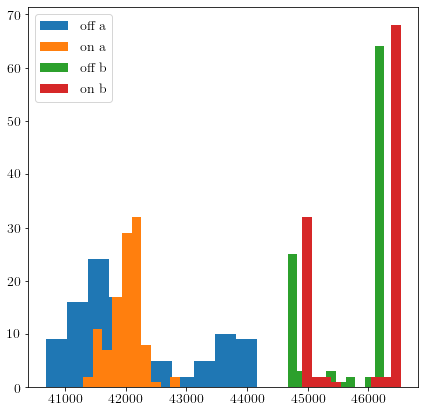

In [243]:
fig , ax = plt.subplots(1,figsize=(7,7))
ax.hist(off[0::2][:,4].astype(float),bins=10);
ax.hist(on[0::2][:,4].astype(float),bins=10);

ax.hist(off[1::2][:,4].astype(float),bins=10);
ax.hist(on[1::2][:,4].astype(float),bins=10);

ax.legend(['off a', 'on a', 'off b', 'on b'])

In [33]:
off[1::2];

NameError: name 'off' is not defined

array([45016., 46501., 44488., 46490., 44383., 46539., 44137., 46510.,
       44299., 46512., 43974., 46470., 44318., 46488., 44458., 46476.,
       44835., 46500., 45276., 46491., 45046., 46484., 44847., 46489.,
       45226., 46499., 45296., 46557., 45020., 46530., 44382., 46529.,
       45432., 46542., 45862., 46562., 46389., 46507., 45874., 46490.,
       45429., 46490., 45128., 46470., 44657., 46480., 44798., 46467.,
       45565., 46522., 46312., 46530., 46453., 46544., 46328., 46557.,
       45849., 46588., 45657., 46555., 44695., 46518., 44634., 46502.,
       45219., 46494., 44652., 46507., 45482., 46543., 45743., 46565.,
       45380., 46540., 45357., 46554., 45151., 46566., 45604., 46554.,
       45929., 46602., 45107., 46578., 45174., 46559., 45192., 46603.,
       45226., 46587., 45416., 46577., 44988., 46549., 44417., 46514.,
       45189., 46534., 45204., 46501., 45221., 46513., 45251., 46519.,
       45488., 46518., 45471., 46505., 45473., 46498., 44795., 46478.,
      